# Introduction

In this notebook I'm going to gather all features that will be used for building a classification model, conduct some preprocessing and feature engineering so it's ready to use without further operations (excluding transformations that can be optimized in a gridsearch).

The goal of the machine learning model will be to predict the direction of a gas price change in the next day (whether it's going up or going down). Knowing the purpose I'm going to explain rationale behind every feature:
- gas daily change: some of the markets are trending (for most of the time) while other are usually going back to the mean; there might be a relation between today's and yesterday's direction of the price change (positive or negative)


- gas volatility: on some markets price decrease is usually more dynamic than growth (in terms of rate of fluctuations - this is especially true in the stock markets), so the price volatility might indicate the next day price direction 


- gas daily gap: that's a gap between today's opening and previous day closing price (as a percentage of that price); again, it might indicate a direction of a price change - one way (closing the gap) or the other (following its direction)


- rate 2Y daily change: 2 years interest rate might be an indicator of American economic situation, investment conditions and so on


- SP500 daily change: it might be seen as a measure of economic development or recession


- WTI daily change: some of the natural gas is a by-product of oil production - possibly oil price growth cause gas price decrease as it's increasing supply


- EURUSD: in some way it might be showing the relation between strength of US and the rest of the world economies, also how attractive buying commodities denominated in USD is 


- TTF daily change: dutch gas price change from the previous day - it's entirely different market, but some non-straight connections might occur


- storage: the level of supply that's gathered in the gas storages - the more, the cheaper a gas should be


- GDP quarterly change: another way of showing economic development or recession in the United States


- US temperatures: some dependency between average temperatures in every month and gas prices might be sound as gas is used among others for heating houses in the winter.

In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Downloading data

## Natural gas

In [2]:
gas_raw = quandl.get("CHRIS/CME_NG1", api_key = 'ynAYQ_qMgK3dad1g26eo')
# after some preprocessing this dataframe will contain some model features and the target (y)
gas_raw.sort_index(ascending=False, inplace = True)
gas_raw

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2020-03-23,1.533,1.628,1.519,1.586,0.002,1.602,129831.0,68621.0
2020-03-20,1.647,1.700,1.574,1.577,0.050,1.604,152925.0,88777.0
2020-03-19,1.632,1.683,1.602,1.650,0.050,1.654,184205.0,130558.0
2020-03-18,1.721,1.728,1.555,1.635,0.125,1.604,215033.0,139038.0
2020-03-17,1.797,1.820,1.711,1.720,0.086,1.729,151172.0,161697.0
...,...,...,...,...,...,...,...,...
1990-04-09,1.612,1.640,1.612,1.637,NaN,1.637,37.0,145.0
1990-04-06,1.615,1.635,1.610,1.625,NaN,1.625,62.0,136.0
1990-04-05,1.615,1.635,1.610,1.615,NaN,1.615,57.0,112.0


In [3]:
isinstance(gas_raw.index, pd.DatetimeIndex)

True

In [4]:
gas_raw.index.is_all_dates # just an alternative way to check the same thing

True

In [5]:
gas_raw.isna().sum()

Open                             0
High                             0
Low                              0
Last                             0
Change                        5987
Settle                           0
Volume                           0
Previous Day Open Interest       0
dtype: int64

In [6]:
gas = gas_raw.drop(columns = ['Change', 'Last'])
gas.columns =['gas_open', 'gas_high', 'gas_low', 'gas_settle', 'gas_volume', 'gas_prevdayopeninterest']
gas.head()

,gas_open,gas_high,gas_low,gas_settle,gas_volume,gas_prevdayopeninterest
Date,,,,,,
2020-03-23,1.533,1.628,1.519,1.602,129831.0,68621.0
2020-03-20,1.647,1.700,1.574,1.604,152925.0,88777.0
2020-03-19,1.632,1.683,1.602,1.654,184205.0,130558.0
2020-03-18,1.721,1.728,1.555,1.604,215033.0,139038.0
2020-03-17,1.797,1.820,1.711,1.729,151172.0,161697.0


## US 2Y interest rate

In [7]:
US_IR_raw = quandl.get("USTREASURY/YIELD", api_key = 'ynAYQ_qMgK3dad1g26eo')
US_IR_raw.sort_index(ascending = False, inplace = True)
US_IR_raw.head(3)

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2020-03-23,0.01,0.04,0.02,0.08,0.17,0.28,0.31,0.38,0.63,0.76,1.12,1.33
2020-03-20,0.04,0.05,0.05,0.05,0.15,0.37,0.41,0.52,0.82,0.92,1.35,1.55
2020-03-19,0.04,0.04,0.04,0.06,0.20,0.44,0.53,0.66,1.00,1.12,1.56,1.78


In [8]:
US_IR = US_IR_raw[['2 YR']]
US_IR.columns = ['US_rate_2y']
US_IR.head(3)

,US_rate_2y
Date,
2020-03-23,0.28
2020-03-20,0.37
2020-03-19,0.44


In [9]:
isinstance(US_IR.index, pd.DatetimeIndex)

True

## S&P500

In [10]:
SP500_raw = pd.read_csv('Data/^spx_d.csv', index_col= 'Data')
SP500_raw.sort_index(ascending = False, inplace = True)
SP500_raw.index = pd.to_datetime(SP500_raw.index)
SP500_raw.head(3)

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
Data,,,,,
2020-03-13,2569.99,2711.33,2492.37,2711.02,NaN
2020-03-12,2630.86,2660.95,2478.86,2480.64,1.432305e+09
2020-03-11,2825.60,2825.60,2707.22,2741.38,1.122243e+09


In [11]:
isinstance(SP500_raw.index, pd.DatetimeIndex)

True

In [12]:
SP500 = SP500_raw[['Zamkniecie']]
SP500.columns = ['SP500_close']
SP500.head()

,SP500_close
Data,
2020-03-13,2711.02
2020-03-12,2480.64
2020-03-11,2741.38
2020-03-10,2882.23
2020-03-09,2746.56


## Crude oil WTI

In [13]:
WTI_raw = quandl.get("CHRIS/CME_CL1", api_key = 'ynAYQ_qMgK3dad1g26eo')
WTI_raw.sort_index(ascending=False, inplace=True)
WTI_raw

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2020-03-23,22.52,24.07,20.80,23.78,0.73,23.36,845079.0,541043.0
2020-03-20,24.73,27.89,19.46,19.84,2.79,22.43,18012.0,18004.0
2020-03-19,22.30,27.71,21.36,25.08,4.85,25.22,126844.0,65171.0
2020-03-18,26.94,27.22,20.06,22.39,6.58,20.37,300793.0,82259.0
2020-03-17,28.69,30.30,26.63,26.82,1.75,26.95,536153.0,138291.0
...,...,...,...,...,...,...,...,...
1983-04-06,29.90,29.92,29.65,29.90,NaN,29.90,392.0,640.0
1983-04-05,29.50,29.80,29.50,29.71,NaN,29.71,175.0,623.0
1983-04-04,29.30,29.70,29.29,29.44,NaN,29.44,156.0,583.0


In [14]:
isinstance(WTI_raw.index, pd.DatetimeIndex)

True

In [15]:
WTI_raw.isna().sum()

Open                             0
High                             0
Low                              0
Last                             0
Change                        7763
Settle                           0
Volume                           0
Previous Day Open Interest       1
dtype: int64

In [16]:
WTI = WTI_raw.drop(columns = ['Change', 'Last'])
WTI.columns = ['WTI_open', 'WTI_high', 'WTI_low', 'WTI_settle', 'WTI_volume', 'WTI_prevdayopeninterest']
WTI.head()

,WTI_open,WTI_high,WTI_low,WTI_settle,WTI_volume,WTI_prevdayopeninterest
Date,,,,,,
2020-03-23,22.52,24.07,20.80,23.36,845079.0,541043.0
2020-03-20,24.73,27.89,19.46,22.43,18012.0,18004.0
2020-03-19,22.30,27.71,21.36,25.22,126844.0,65171.0
2020-03-18,26.94,27.22,20.06,20.37,300793.0,82259.0
2020-03-17,28.69,30.30,26.63,26.95,536153.0,138291.0


## EUR/USD

In [17]:
EURUSD = quandl.get("ECB/EURUSD", api_key = 'ynAYQ_qMgK3dad1g26eo')
EURUSD.sort_index(ascending=False, inplace=True)
EURUSD.rename({'Value':"EurUsd"}, axis=1, inplace=True)
EURUSD

,EurUsd
Date,
2020-03-23,1.0783
2020-03-20,1.0707
2020-03-19,1.0801
2020-03-18,1.0934
2020-03-17,1.0982
...,...
1999-01-08,1.1659
1999-01-07,1.1632
1999-01-06,1.1743


In [18]:
isinstance(EURUSD.index, pd.DatetimeIndex)

True

In [19]:
EURUSD.isna().sum()

EurUsd    0
dtype: int64

## Dutch gas TTF

In [20]:
TTF_raw = quandl.get("CHRIS/ICE_TFM1", api_key = 'ynAYQ_qMgK3dad1g26eo')
TTF_raw.sort_index(ascending=False, inplace=True)
TTF_raw

,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
Date,,,,,,,,,,,
2020-03-23,7.750,8.100,7.750,7.849,-0.444,7.946,18685.0,84026.0,4165.0,NaN,5030.0
2020-03-20,8.450,8.710,8.200,8.293,-0.251,8.439,23935.0,86499.0,1100.0,1463.0,2358.0
2020-03-19,8.260,8.595,8.260,8.544,0.279,8.461,20905.0,87506.0,100.0,NaN,3094.0
2020-03-18,8.350,8.400,8.155,8.265,-0.205,8.294,21265.0,91001.0,NaN,NaN,3010.0
2020-03-17,8.775,8.775,8.400,8.470,-0.271,8.497,20560.0,89497.0,NaN,20.0,5085.0
...,...,...,...,...,...,...,...,...,...,...,...
2013-10-11,27.075,27.100,27.075,27.100,-0.050,NaN,195.0,9625.0,NaN,NaN,NaN
2013-10-10,27.210,27.210,27.150,27.150,-0.138,NaN,360.0,9550.0,NaN,NaN,NaN
2013-10-09,27.330,27.350,27.250,27.288,0.038,NaN,1640.0,8360.0,NaN,NaN,NaN


In [21]:
isinstance(TTF_raw.index, pd.DatetimeIndex)

True

In [22]:
TTF = TTF_raw.iloc[:,[0, 1, 2, 3, 6, 7]]
TTF.columns = ['TTF_open', 'TTF_high', 'TTF_low', 'TTF_settle', 'TTF_volume', 'TTF_prevdayopeninterest']
TTF.head()

,TTF_open,TTF_high,TTF_low,TTF_settle,TTF_volume,TTF_prevdayopeninterest
Date,,,,,,
2020-03-23,7.750,8.100,7.750,7.849,18685.0,84026.0
2020-03-20,8.450,8.710,8.200,8.293,23935.0,86499.0
2020-03-19,8.260,8.595,8.260,8.544,20905.0,87506.0
2020-03-18,8.350,8.400,8.155,8.265,21265.0,91001.0
2020-03-17,8.775,8.775,8.400,8.470,20560.0,89497.0


In [23]:
TTF.isna().sum()

TTF_open                    7
TTF_high                    7
TTF_low                     7
TTF_settle                  0
TTF_volume                 17
TTF_prevdayopeninterest     1
dtype: int64

## Gas inventory - EIA report

In [24]:
# this data is taken from http://ir.eia.gov/ngs/ngs.html
Gas_inv_raw = pd.read_excel('Data/Gas_Inventory.xlsx', skiprows=6, index_col='Week ending')
Gas_inv_raw.sort_index(ascending=False, inplace=True)
Gas_inv_raw.head()

,Source,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
Week ending,,,,,,,,,
2020-03-06,EIA-912,426,529,97,200,791,235,556,2043
2020-02-28,EIA-912,451,558,101,197,784,229,555,2091
2020-02-21,EIA-912,484,591,108,196,821,244,578,2200
2020-02-14,EIA-912,527,639,117,198,861,257,605,2343
2020-02-07,EIA-912,569,694,126,202,903,269,634,2494


In [25]:
Gas_inv = Gas_inv_raw.copy()
Gas_inv['Report_date'] = Gas_inv.index + pd.DateOffset(days=6) # the report is published
# 6 days after the week it describes (therefore date needs to be shifted so there's no
# data leak)
Gas_inv.set_index(['Report_date'], inplace=True)
Gas_inv = Gas_inv[['Total Lower 48']]
Gas_inv.columns = ['Storage']
Gas_inv

,Storage
Report_date,
2020-03-12,2043
2020-03-05,2091
2020-02-27,2200
2020-02-20,2343
2020-02-13,2494
...,...
2010-02-04,2406
2010-01-28,2521
2010-01-21,2607


In [26]:
Gas_inv = Gas_inv.resample('d').ffill()
Gas_inv.tail(10)

,Storage
Report_date,
2020-03-03,2200
2020-03-04,2200
2020-03-05,2091
2020-03-06,2091
2020-03-07,2091
2020-03-08,2091
2020-03-09,2091
2020-03-10,2091
2020-03-11,2091


## US GDP

In [27]:
GDP = quandl.get("FRED/GDPC1", api_key = 'ynAYQ_qMgK3dad1g26eo')
GDP.sort_index(ascending=False, inplace=True)
GDP

,Value
Date,
2019-10-01,19220.490
2019-07-01,19121.112
2019-04-01,19021.860
2019-01-01,18927.281
2018-10-01,18783.548
...,...
1948-01-01,2086.017
1947-10-01,2055.103
1947-07-01,2023.452


In [28]:
isinstance(GDP.index, pd.DatetimeIndex)

True

In [29]:
GDP.isna().sum()

Value    0
dtype: int64

## US average monthly temperatures

In [30]:
temps_avg = pd.read_pickle('Data/temps_pca_rep.pkl')
temps_avg

,US_temp
2010-01-01,149.463355
2010-01-02,149.463355
2010-01-03,149.463355
2010-01-04,149.463355
2010-01-05,149.463355
...,...
2029-11-27,62.166491
2029-11-28,62.166491
2029-11-29,62.166491
2029-11-30,62.166491


# Data preprocessing

## Natural gas

In [31]:
gas.head()

,gas_open,gas_high,gas_low,gas_settle,gas_volume,gas_prevdayopeninterest
Date,,,,,,
2020-03-23,1.533,1.628,1.519,1.602,129831.0,68621.0
2020-03-20,1.647,1.700,1.574,1.604,152925.0,88777.0
2020-03-19,1.632,1.683,1.602,1.654,184205.0,130558.0
2020-03-18,1.721,1.728,1.555,1.604,215033.0,139038.0
2020-03-17,1.797,1.820,1.711,1.729,151172.0,161697.0


In [32]:
gas['gas_daily_change'] = gas.gas_settle/gas.gas_settle.shift(-1)-1
gas['gas_volatility'] = (gas.gas_high-gas.gas_low)/gas.gas_settle
gas['gas_daily_gap'] = (gas.gas_open-gas.gas_settle.shift(-1))/gas.gas_settle.shift(-1)
gas['gas_target'] = np.where(gas['gas_daily_change']>=0, 1, 0)
gas['gas_target'] = gas['gas_target'].shift(1)
gas.head()

,gas_open,gas_high,gas_low,gas_settle,gas_volume,gas_prevdayopeninterest,gas_daily_change,gas_volatility,gas_daily_gap,gas_target
Date,,,,,,,,,,
2020-03-23,1.533,1.628,1.519,1.602,129831.0,68621.0,-0.001247,0.068040,-0.044264,NaN
2020-03-20,1.647,1.700,1.574,1.604,152925.0,88777.0,-0.030230,0.078554,-0.004232,0.0
2020-03-19,1.632,1.683,1.602,1.654,184205.0,130558.0,0.031172,0.048972,0.017456,0.0
2020-03-18,1.721,1.728,1.555,1.604,215033.0,139038.0,-0.072296,0.107855,-0.004627,1.0
2020-03-17,1.797,1.820,1.711,1.729,151172.0,161697.0,-0.047383,0.063042,-0.009917,0.0


In [33]:
gas_pr = gas.drop(columns=['gas_open', 'gas_high', 'gas_low',
                           'gas_settle', 'gas_volume', 'gas_prevdayopeninterest'])
gas_pr.head(10)

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target
Date,,,,
2020-03-23,-0.001247,0.068040,-0.044264,NaN
2020-03-20,-0.030230,0.078554,-0.004232,0.0
2020-03-19,0.031172,0.048972,0.017456,0.0
2020-03-18,-0.072296,0.107855,-0.004627,1.0
2020-03-17,-0.047383,0.063042,-0.009917,0.0
2020-03-16,-0.028892,0.041873,-0.008026,0.0
2020-03-13,0.015209,0.083467,-0.016839,0.0
2020-03-12,-0.019702,0.072243,0.002662,1.0
2020-03-11,-0.029959,0.073482,0.001033,0.0


In [34]:
gas_pr.shape

(7515, 4)

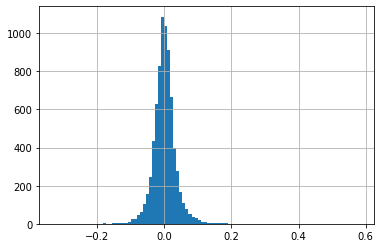

In [35]:
(gas_pr.gas_daily_change).hist(bins=100)
plt.show()

Brief look at the gas daily percentage change (rate of return) histogram shows it's similar to Gaussian distribution. It can be further investigated (using e.g. QQ-plot or statistical tests like Kolmogorov-Smirnov or Shapiro-Wilk).

In [36]:
gas_pr[gas_pr.isna().any(axis=1)]

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target
Date,,,,
2020-03-23,-0.001247,0.068040,-0.044264,NaN
1990-04-03,NaN,0.045872,NaN,0.0


In [37]:
gas_pr.dropna(inplace=True)
gas_pr.shape

(7513, 4)

In [38]:
round(gas_pr.gas_daily_change.quantile(0.1), 2), \
round(gas_pr.gas_daily_change.quantile(0.5), 2), \
round(gas_pr.gas_daily_change.quantile(0.9), 2)

(-0.04, -0.0, 0.04)

## US 2Y interest rate

In [39]:
US_IR

,US_rate_2y
Date,
2020-03-23,0.28
2020-03-20,0.37
2020-03-19,0.44
2020-03-18,0.54
2020-03-17,0.47
...,...
1990-01-08,7.90
1990-01-05,7.90
1990-01-04,7.92


In [40]:
US_IR['rate_2y_daily_change'] = US_IR.US_rate_2y/US_IR.US_rate_2y.shift(-1)-1
US_IR

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,US_rate_2y,rate_2y_daily_change
Date,,
2020-03-23,0.28,-0.243243
2020-03-20,0.37,-0.159091
2020-03-19,0.44,-0.185185
2020-03-18,0.54,0.148936
2020-03-17,0.47,0.305556
...,...,...
1990-01-08,7.90,0.000000
1990-01-05,7.90,-0.002525
1990-01-04,7.92,-0.002519


In [41]:
US_IR_pr = pd.DataFrame(US_IR.rate_2y_daily_change)
US_IR_pr.head()

,rate_2y_daily_change
Date,
2020-03-23,-0.243243
2020-03-20,-0.159091
2020-03-19,-0.185185
2020-03-18,0.148936
2020-03-17,0.305556


C:\Users\PC\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


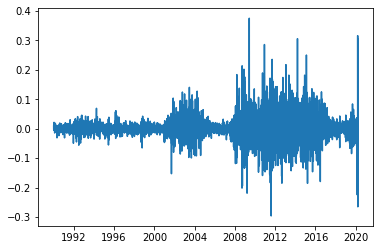

In [42]:
plt.plot(US_IR['rate_2y_daily_change'])
plt.show()

## S&P500

In [43]:
SP500

,SP500_close
Data,
2020-03-13,2711.02
2020-03-12,2480.64
2020-03-11,2741.38
2020-03-10,2882.23
2020-03-09,2746.56
...,...
2000-05-05,1432.63
2000-05-04,1409.38
2000-05-03,1415.10


In [44]:
SP500['SP500_daily_change'] = SP500.SP500_close/SP500.SP500_close.shift(-1)-1
SP500

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SP500_close,SP500_daily_change
Data,,
2020-03-13,2711.02,0.092871
2020-03-12,2480.64,-0.095113
2020-03-11,2741.38,-0.048868
2020-03-10,2882.23,0.049396
2020-03-09,2746.56,-0.075970
...,...,...
2000-05-05,1432.63,0.016497
2000-05-04,1409.38,-0.004042
2000-05-03,1415.10,-0.021430


In [45]:
SP500_pr = SP500.drop(columns=['SP500_close'])
SP500_pr.head()

,SP500_daily_change
Data,
2020-03-13,0.092871
2020-03-12,-0.095113
2020-03-11,-0.048868
2020-03-10,0.049396
2020-03-09,-0.075970


## Crude oil WTI

In [46]:
WTI

,WTI_open,WTI_high,WTI_low,WTI_settle,WTI_volume,WTI_prevdayopeninterest
Date,,,,,,
2020-03-23,22.52,24.07,20.80,23.36,845079.0,541043.0
2020-03-20,24.73,27.89,19.46,22.43,18012.0,18004.0
2020-03-19,22.30,27.71,21.36,25.22,126844.0,65171.0
2020-03-18,26.94,27.22,20.06,20.37,300793.0,82259.0
2020-03-17,28.69,30.30,26.63,26.95,536153.0,138291.0
...,...,...,...,...,...,...
1983-04-06,29.90,29.92,29.65,29.90,392.0,640.0
1983-04-05,29.50,29.80,29.50,29.71,175.0,623.0
1983-04-04,29.30,29.70,29.29,29.44,156.0,583.0


In [47]:
WTI['WTI_daily_change'] = WTI.WTI_settle/WTI.WTI_settle.shift(-1)-1
WTI

,WTI_open,WTI_high,WTI_low,WTI_settle,WTI_volume,WTI_prevdayopeninterest,WTI_daily_change
Date,,,,,,,
2020-03-23,22.52,24.07,20.80,23.36,845079.0,541043.0,0.041462
2020-03-20,24.73,27.89,19.46,22.43,18012.0,18004.0,-0.110626
2020-03-19,22.30,27.71,21.36,25.22,126844.0,65171.0,0.238095
2020-03-18,26.94,27.22,20.06,20.37,300793.0,82259.0,-0.244156
2020-03-17,28.69,30.30,26.63,26.95,536153.0,138291.0,-0.060976
...,...,...,...,...,...,...,...
1983-04-06,29.90,29.92,29.65,29.90,392.0,640.0,0.006395
1983-04-05,29.50,29.80,29.50,29.71,175.0,623.0,0.009171
1983-04-04,29.30,29.70,29.29,29.44,156.0,583.0,0.005121


In [48]:
WTI_pr = pd.DataFrame(WTI.WTI_daily_change)
WTI_pr.head()

,WTI_daily_change
Date,
2020-03-23,0.041462
2020-03-20,-0.110626
2020-03-19,0.238095
2020-03-18,-0.244156
2020-03-17,-0.060976


## EURUSD

In [49]:
EURUSD

,EurUsd
Date,
2020-03-23,1.0783
2020-03-20,1.0707
2020-03-19,1.0801
2020-03-18,1.0934
2020-03-17,1.0982
...,...
1999-01-08,1.1659
1999-01-07,1.1632
1999-01-06,1.1743


## Dutch gas TTF

TTF gas is traded on the european exchange, its quotation is in Euros. It doesn't matter though as I'm going to extract daily rates of return and units don't affect it.

In [50]:
TTF

,TTF_open,TTF_high,TTF_low,TTF_settle,TTF_volume,TTF_prevdayopeninterest
Date,,,,,,
2020-03-23,7.750,8.100,7.750,7.849,18685.0,84026.0
2020-03-20,8.450,8.710,8.200,8.293,23935.0,86499.0
2020-03-19,8.260,8.595,8.260,8.544,20905.0,87506.0
2020-03-18,8.350,8.400,8.155,8.265,21265.0,91001.0
2020-03-17,8.775,8.775,8.400,8.470,20560.0,89497.0
...,...,...,...,...,...,...
2013-10-11,27.075,27.100,27.075,27.100,195.0,9625.0
2013-10-10,27.210,27.210,27.150,27.150,360.0,9550.0
2013-10-09,27.330,27.350,27.250,27.288,1640.0,8360.0


In [51]:
TTF['TTF_daily_change'] = TTF.TTF_settle/TTF.TTF_settle.shift(-1)-1
TTF

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TTF_open,TTF_high,TTF_low,TTF_settle,TTF_volume,TTF_prevdayopeninterest,TTF_daily_change
Date,,,,,,,
2020-03-23,7.750,8.100,7.750,7.849,18685.0,84026.0,-0.053539
2020-03-20,8.450,8.710,8.200,8.293,23935.0,86499.0,-0.029377
2020-03-19,8.260,8.595,8.260,8.544,20905.0,87506.0,0.033757
2020-03-18,8.350,8.400,8.155,8.265,21265.0,91001.0,-0.024203
2020-03-17,8.775,8.775,8.400,8.470,20560.0,89497.0,-0.031003
...,...,...,...,...,...,...,...
2013-10-11,27.075,27.100,27.075,27.100,195.0,9625.0,-0.001842
2013-10-10,27.210,27.210,27.150,27.150,360.0,9550.0,-0.005057
2013-10-09,27.330,27.350,27.250,27.288,1640.0,8360.0,0.001394


In [52]:
TTF_pr = pd.DataFrame(TTF.TTF_daily_change)
TTF_pr.head()

,TTF_daily_change
Date,
2020-03-23,-0.053539
2020-03-20,-0.029377
2020-03-19,0.033757
2020-03-18,-0.024203
2020-03-17,-0.031003


## Gas inventory - EIA report

In [53]:
Gas_inv.head()

,Storage
Report_date,
2010-01-07,3117
2010-01-08,3117
2010-01-09,3117
2010-01-10,3117
2010-01-11,3117


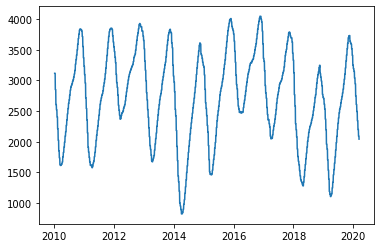

In [54]:
plt.plot(Gas_inv)
plt.show()

Plot shows that the data has a seasonal component. It's not a surprise as it's the level of gas storage - it decreases in winter time and increases in spring-summer.

For now I'm going to leave this series as it is, but reducing seasonal component might be worth considering.

## US GDP

In [55]:
GDP

,Value
Date,
2019-10-01,19220.490
2019-07-01,19121.112
2019-04-01,19021.860
2019-01-01,18927.281
2018-10-01,18783.548
...,...
1948-01-01,2086.017
1947-10-01,2055.103
1947-07-01,2023.452


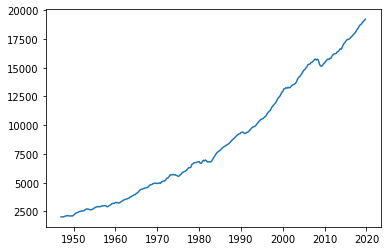

In [56]:
plt.plot(GDP)
plt.show()

Obviously GDP is a non-stationary series as economical growth and inflation make it rise over time. It needs to be transformed and resampled (right now it's quarterly data).

In [57]:
GDP['GDP_quarterly_change'] = GDP.Value/GDP.Value.shift(-1)-1
GDP

,Value,GDP_quarterly_change
Date,,
2019-10-01,19220.490,0.005197
2019-07-01,19121.112,0.005218
2019-04-01,19021.860,0.004997
2019-01-01,18927.281,0.007652
2018-10-01,18783.548,0.002713
...,...,...
1948-01-01,2086.017,0.015043
1947-10-01,2055.103,0.015642
1947-07-01,2023.452,-0.002065


In [58]:
GDP_pr = pd.DataFrame(GDP.GDP_quarterly_change)
GDP_pr.head()

,GDP_quarterly_change
Date,
2019-10-01,0.005197
2019-07-01,0.005218
2019-04-01,0.004997
2019-01-01,0.007652
2018-10-01,0.002713


In [59]:
GDP_pr_res = GDP_pr.resample('d').ffill()
GDP_pr_res.tail()

,GDP_quarterly_change
Date,
2019-09-27,0.005218
2019-09-28,0.005218
2019-09-29,0.005218
2019-09-30,0.005218
2019-10-01,0.005197


# Concatenating all features and dataframe processing

## Concatenate

In [60]:
X = pd.merge(gas_pr, US_IR_pr, left_index=True, right_index=True, how='left')

for df in [SP500_pr, WTI_pr, EURUSD, TTF_pr, Gas_inv, GDP_pr, temps_avg]:
    X = pd.merge(X, df, left_index=True, right_index=True, how='left')
    
X.head(20)

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp
Date,,,,,,,,,,,,
2020-03-20,-0.030230,0.078554,-0.004232,0.0,-0.159091,NaN,-0.110626,1.0707,-0.029377,NaN,NaN,75.360065
2020-03-19,0.031172,0.048972,0.017456,0.0,-0.185185,NaN,0.238095,1.0801,0.033757,NaN,NaN,75.360065
2020-03-18,-0.072296,0.107855,-0.004627,1.0,0.148936,NaN,-0.244156,1.0934,-0.024203,NaN,NaN,75.360065
2020-03-17,-0.047383,0.063042,-0.009917,0.0,0.305556,NaN,-0.060976,1.0982,-0.031003,NaN,NaN,75.360065
2020-03-16,-0.028892,0.041873,-0.008026,0.0,-0.265306,NaN,-0.095493,1.1157,-0.058589,NaN,NaN,75.360065
2020-03-13,0.015209,0.083467,-0.016839,0.0,-0.020000,0.092871,0.007302,1.1104,-0.004183,NaN,NaN,75.360065
2020-03-12,-0.019702,0.072243,0.002662,1.0,0.000000,-0.095113,-0.044876,1.1240,-0.004803,2043.0,NaN,75.360065
2020-03-11,-0.029959,0.073482,0.001033,0.0,0.000000,-0.048868,-0.040163,1.1336,0.041810,2091.0,NaN,75.360065
2020-03-10,0.088864,0.083161,0.032058,0.0,0.315789,0.049396,0.103758,1.1390,0.042425,2091.0,NaN,75.360065


## Null values

In [61]:
fill_with_bfill = ['Storage', 'GDP_quarterly_change', 'EurUsd']
fill_with_0 = ['rate_2y_daily_change', 'SP500_daily_change', 'WTI_daily_change', 'TTF_daily_change']

for column in fill_with_bfill:
    
    X[column].bfill(inplace=True)

    
for column in fill_with_0:
    
    X[column].fillna(0, inplace=True)

In [62]:
X

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp
Date,,,,,,,,,,,,
2020-03-20,-0.030230,0.078554,-0.004232,0.0,-0.159091,0.0,-0.110626,1.0707,-0.029377,2043.0,0.005197,75.360065
2020-03-19,0.031172,0.048972,0.017456,0.0,-0.185185,0.0,0.238095,1.0801,0.033757,2043.0,0.005197,75.360065
2020-03-18,-0.072296,0.107855,-0.004627,1.0,0.148936,0.0,-0.244156,1.0934,-0.024203,2043.0,0.005197,75.360065
2020-03-17,-0.047383,0.063042,-0.009917,0.0,0.305556,0.0,-0.060976,1.0982,-0.031003,2043.0,0.005197,75.360065
2020-03-16,-0.028892,0.041873,-0.008026,0.0,-0.265306,0.0,-0.095493,1.1157,-0.058589,2043.0,0.005197,75.360065
...,...,...,...,...,...,...,...,...,...,...,...,...
1990-04-10,-0.010385,0.010494,-0.007330,0.0,0.000000,0.0,-0.041215,NaN,0.000000,NaN,NaN,NaN
1990-04-09,0.007385,0.017104,-0.008000,0.0,0.002347,0.0,-0.037076,NaN,0.000000,NaN,NaN,NaN
1990-04-06,0.006192,0.015385,0.000000,1.0,-0.002342,0.0,-0.014411,NaN,0.000000,NaN,NaN,NaN


I'm going to use last 10 years (2010-today) to prepare a model - as financial markets evolve, past behaviour might be not good indicator of the future price movements and using data that's too old might intensify this issue.

In [63]:
X = X[X.index.year >= 2010]

In [64]:
X.isna().sum()

gas_daily_change        0
gas_volatility          0
gas_daily_gap           0
gas_target              0
rate_2y_daily_change    0
SP500_daily_change      0
WTI_daily_change        0
EurUsd                  0
TTF_daily_change        0
Storage                 2
GDP_quarterly_change    0
US_temp                 0
dtype: int64

There are still null values in the Storage column - probably at the very beginning (where bfill didn't have any effect) - let's see:

In [65]:
X[X.Storage.isna()]

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp
Date,,,,,,,,,,,,
2010-01-06,0.021244,0.070727,-0.032971,0.0,0.00000,0.000546,0.017243,1.4350,0.0,NaN,0.010984,149.463355
2010-01-04,0.055994,0.032121,0.023869,1.0,-0.04386,0.016043,0.027092,1.4389,0.0,NaN,0.010984,149.463355


That's exactly the case, so I'll just remove these 2 days from my dataset. I'll do it later though as I'm going to add some features lags that will also cause null values and by taking this order I'll save 2 observations.

# Adding new features

## Weekday

In [66]:
# I'm going to add weekday as a new feature and then transform it into 5 columns, each represting 1 day of a week.
# Days of the week can be represented by numbers, but these numbers are just labels that don't show any internal value.
X['Weekday'] = X.index.weekday_name
X = pd.concat([X, pd.get_dummies(X.Weekday)], axis=1)
X.drop(columns=['Weekday'], inplace = True)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Gas storages filling

In [67]:
# This feature roughly (as it's weather-dependant and might differ every year) shows whether gas storages
# are in a cycle of filling or emptying (from November to end of the March)
X['filling'] = [x in [11, 12, 1, 2, 3] for x in X.index.month]

## Lags of the gas price change

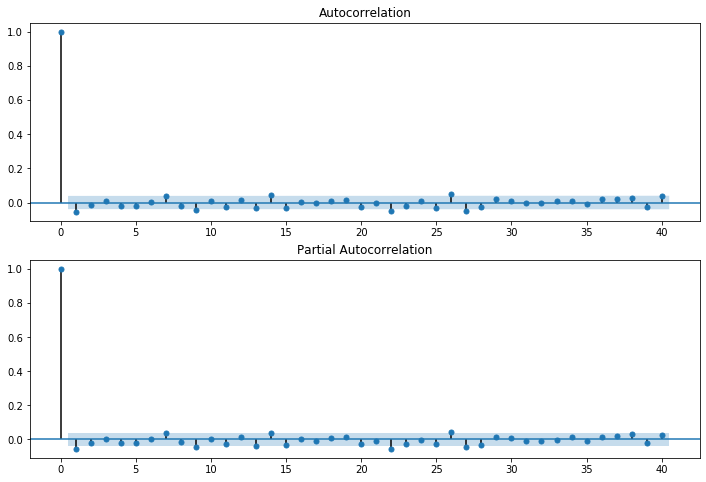

In [68]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(X.gas_daily_change, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(X.gas_daily_change, lags=40, ax=ax2)
plt.show()

In [69]:
PACF = pacf(X.gas_daily_change)

for i in enumerate(PACF):
    if abs(i[1]) > 0.05:
        print(f'{i[0]}:  {i[1].round(2)}')

0:  1.0
1:  -0.05
22:  -0.05


PACF function tells us that 1st and 22nd lag of the gas daily change has some statistically significant correlation. 1st lag seems to have some sense, but 22nd lag is surprising (probably random), nevertheless I'll add this feature to the dataframe (1st lag is already included as gas_daily_change column - it will be used to predict the next day price move).

In [70]:
X['gas_daily_change_lag22'] = X.gas_daily_change.shift(-21) # lag 21, not 22, for the same reason as explained above
X.head()

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,,
2020-03-20,-0.030230,0.078554,-0.004232,0.0,-0.159091,0.0,-0.110626,1.0707,-0.029377,2043.0,0.005197,75.360065,1,0,0,0,0,True,-0.017903
2020-03-19,0.031172,0.048972,0.017456,0.0,-0.185185,0.0,0.238095,1.0801,0.033757,2043.0,0.005197,75.360065,0,0,1,0,0,True,-0.013125
2020-03-18,-0.072296,0.107855,-0.004627,1.0,0.148936,0.0,-0.244156,1.0934,-0.024203,2043.0,0.005197,75.360065,0,0,0,0,1,True,0.078389
2020-03-17,-0.047383,0.063042,-0.009917,0.0,0.305556,0.0,-0.060976,1.0982,-0.031003,2043.0,0.005197,75.360065,0,0,0,1,0,True,0.006024
2020-03-16,-0.028892,0.041873,-0.008026,0.0,-0.265306,0.0,-0.095493,1.1157,-0.058589,2043.0,0.005197,75.360065,0,1,0,0,0,True,-0.009761


In [71]:
X.dropna(inplace = True)
X.tail()

,gas_daily_change,gas_volatility,gas_daily_gap,gas_target,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,,
2010-02-10,0.000378,0.026455,0.010964,1.0,0.083333,-0.002233,0.010441,1.3740,0.0,2406.0,0.010984,126.992186,0,0,0,0,1,True,-0.051313
2010-02-09,-0.020552,0.038563,0.003518,1.0,0.063291,0.013040,0.025873,1.3760,0.0,2406.0,0.010984,126.992186,0,0,0,1,0,True,-0.009817
2010-02-08,-0.020671,0.052583,0.015775,0.0,0.025974,-0.008863,0.009833,1.3675,0.0,2406.0,0.010984,126.992186,0,1,0,0,0,True,-0.033783
2010-02-05,0.018279,0.038985,0.012740,0.0,-0.037500,0.002897,-0.026661,1.3691,0.0,2406.0,0.010984,126.992186,1,0,0,0,0,True,0.021244
2010-02-04,-0.000554,0.050406,-0.002399,1.0,-0.090909,-0.031141,-0.049883,1.3847,0.0,2406.0,0.010984,126.992186,0,0,1,0,0,True,0.055994


# Creating X and y dataframes

In [72]:
y = X.gas_target

In [73]:
X = X.drop(columns=['gas_target'])
X.head()

,gas_daily_change,gas_volatility,gas_daily_gap,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,
2020-03-20,-0.030230,0.078554,-0.004232,-0.159091,0.0,-0.110626,1.0707,-0.029377,2043.0,0.005197,75.360065,1,0,0,0,0,True,-0.017903
2020-03-19,0.031172,0.048972,0.017456,-0.185185,0.0,0.238095,1.0801,0.033757,2043.0,0.005197,75.360065,0,0,1,0,0,True,-0.013125
2020-03-18,-0.072296,0.107855,-0.004627,0.148936,0.0,-0.244156,1.0934,-0.024203,2043.0,0.005197,75.360065,0,0,0,0,1,True,0.078389
2020-03-17,-0.047383,0.063042,-0.009917,0.305556,0.0,-0.060976,1.0982,-0.031003,2043.0,0.005197,75.360065,0,0,0,1,0,True,0.006024
2020-03-16,-0.028892,0.041873,-0.008026,-0.265306,0.0,-0.095493,1.1157,-0.058589,2043.0,0.005197,75.360065,0,1,0,0,0,True,-0.009761


In [74]:
X.to_pickle('Data/X.pkl')
y.to_pickle('Data/y.pkl')